In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pytorch_grad_cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
# from scipy.spatial.distance import cosine
# from torch.nn.functional import cosine_similarity
from torch.utils.data import Dataset
from pytorch_grad_cam.utils.image import show_cam_on_image
import pickle

In [4]:
class MyDataset(Dataset):
    def __init__(self, data):
        self.inputs = data[0][0]
        self.labels = data[0][1]
        self.ground_truth = data[0][2]  

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_data = torch.tensor(self.inputs[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        ground_truth = torch.tensor(self.ground_truth[idx], dtype=torch.float32)  

        return input_data, label, ground_truth

batch_size = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载修改后的数据
with open('train_resize_modified.pkl', 'rb') as file:
    loaded_train_data_resize_modified = pickle.load(file)

with open('test_resize_modified.pkl', 'rb') as file:
    loaded_test_data_resize_modified = pickle.load(file)

# 创建自定义数据集对象
my_train_dataset = MyDataset(loaded_train_data_resize_modified)
my_test_dataset = MyDataset(loaded_test_data_resize_modified)

# 使用 DataLoader 加载数据
train_loader = torch.utils.data.DataLoader(my_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(my_test_dataset, batch_size=batch_size, shuffle=False)


In [5]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)  
checkpoint = torch.load('./checkpoints/resnet18_cifar10_epho10.pth')
model.load_state_dict(checkpoint)

/opt/conda/envs/backdoor/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/backdoor/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [35]:
# 从训练集中获取一些随机图像
dataiter = iter(train_loader)
images, labels, ground_truth = next(dataiter)
target_layers = [model.layer4[-1]]
input_tensor = images

In [36]:
pertub = torch.zeros(1, 3, 224, 224)

In [37]:
img_backdoor = images + pertub

In [38]:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
targets = [ClassifierOutputTarget(label) for label in labels]
# grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

In [39]:
saliency_map = cam(input_tensor=images,targets=targets)
saliency_map_backdoor = cam(input_tensor=img_backdoor,targets=targets)

In [40]:
saliency_map.shape

(4, 224, 224)

In [41]:
ground_truth_ = ground_truth.detach().cpu().numpy()
ground_truth_.shape

(4, 224, 224)

In [42]:
ground_truth_ = saliency_map[0, :]

In [43]:
images_np = images.detach().cpu().numpy()
images_np = np.transpose(images_np, (0, 2, 3, 1))

img_backdoor_np = img_backdoor.detach().cpu().numpy()
img_backdoor_np = np.transpose(images_np, (0, 1, 2, 3))

saliency_map = saliency_map[0, :]
saliency_map_backdoor = saliency_map_backdoor[0, :]

In [44]:
images_np.shape

(4, 224, 224, 3)

In [45]:
img_backdoor_np.shape

(4, 224, 224, 3)

In [46]:
images_np.shape

(4, 224, 224, 3)

In [47]:
visualization_0 = show_cam_on_image(images_np,ground_truth_, use_rgb=True)
visualization_1 = show_cam_on_image(images_np, saliency_map, use_rgb=True)
visualization_2 = show_cam_on_image(img_backdoor_np, saliency_map_backdoor, use_rgb=True)

In [48]:
ground_truth.shape

torch.Size([4, 224, 224])

In [49]:
visualization_1.shape

(4, 224, 224, 3)

In [50]:
# 定义显示图像的函数
def imshow(img):
    img = img / 2 + 0.5     # 反标准化
    npimg = img.numpy() # -> (C, H, W) 
    # print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # -> (H, W, C) 
    plt.axis('off')
    plt.imsave('./img/ori_image.png',np.transpose(npimg, (1, 2, 0)))
    plt.show()

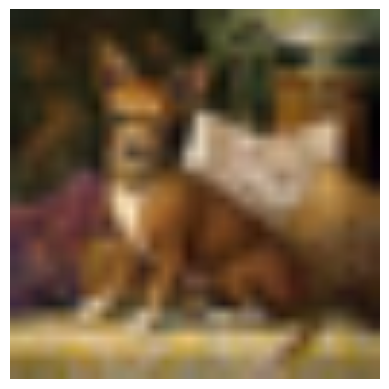

In [51]:
plt.axis('off')
images_np_normalized = (images_np[0] - images_np[0].min()) / (images_np[0].max() - images_np[0].min())
plt.imshow(images_np_normalized)

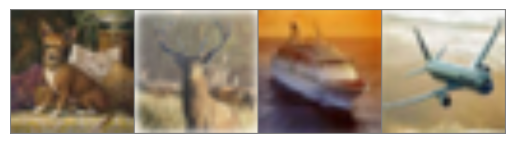

In [52]:
imshow(torchvision.utils.make_grid(images))

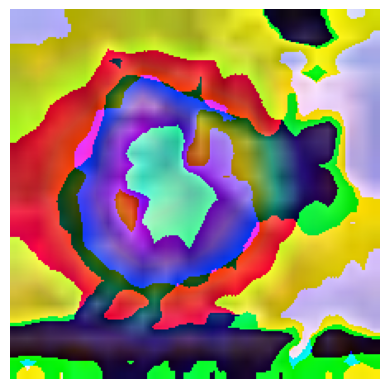

In [53]:
plt.imshow(visualization_0[0])
plt.axis('off')
plt.imsave("./img/ground_truth.png",visualization_1[0])

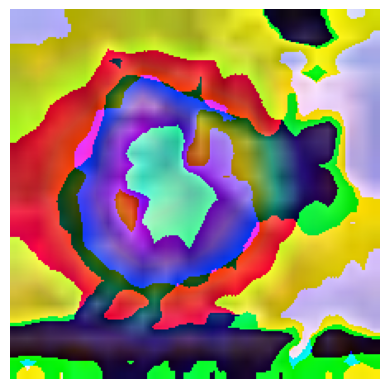

In [54]:
plt.imshow(visualization_1[0])
plt.axis('off')
plt.imsave("./img/saliency_map.png",visualization_1[0])

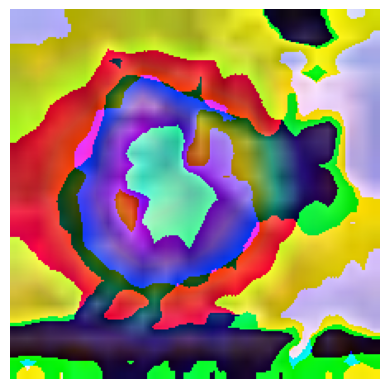

In [55]:
plt.imshow(visualization_2[0])
plt.axis('off')
plt.imsave("./img/saliency_map_backdoor.png",visualization_2[0])